# Resume training of existing model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
os.chdir("/content/drive/My Drive/Inferno")
!pwd

/content/drive/My Drive/Inferno


In [3]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
import h5py
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
#for broken data stream error
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Image preparation

In [0]:
train_path = '/content/drive/My Drive/Inferno/Dataset/train'
valid_path = '/content/drive/My Drive/Inferno/Dataset/valid'
test_path = '/content/drive/My Drive/Inferno/Dataset/test'

In [14]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=512)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=256)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=256, shuffle=False)

Found 38659 images belonging to 2 classes.
Found 9666 images belonging to 2 classes.
Found 11831 images belonging to 2 classes.


### Load existing model and train the model

In [15]:
model = keras.models.load_model('raks_model14.h5')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/Inferno/my_model-{val_acc:.2f}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [0]:
model.fit_generator(train_batches, steps_per_epoch=76, 
                    validation_data=valid_batches, validation_steps=38, epochs=3, verbose=1, callbacks=[checkpointer])

In [0]:
#model.save('my_model22.h5')

### Test the model and plot confusion matrix

In [0]:
test_labels = test_batches.classes

In [17]:
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [18]:
test_batches.class_indices

{'fire': 0, 'nonfire': 1}

In [19]:
predictions = model.predict_generator(test_batches, steps=47, verbose=1)

47/47 [==============================] - 3481s 74s/step


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [22]:
test_batches.class_indices

{'fire': 0, 'nonfire': 1}

Confusion matrix, without normalization
[[2943  219]
 [  20 8649]]


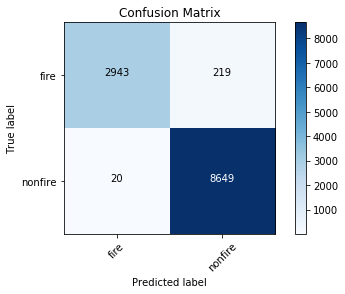

In [23]:
cm_plot_labels = ['fire','nonfire']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')